In [23]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import layers
from tensorflow.keras import losses
import re
import string
import matplotlib.pyplot as plt

In [25]:
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)


<a name="2"></a>
## Load the data


In [26]:
data_dir = './data/aclImdb'

In [27]:
raw_training_set = tf.keras.utils.text_dataset_from_directory(
    f'{data_dir}/train',
    labels='inferred',
    label_mode='int',
    batch_size=32, 
    validation_split=0.2, 
    subset='training', 
    seed=seed
)

raw_validation_set = tf.keras.utils.text_dataset_from_directory(
    f'{data_dir}/train',
    labels='inferred',
    label_mode='int',
    batch_size=32, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed
)

raw_test_set = tf.keras.utils.text_dataset_from_directory(
    f'{data_dir}/test',
    labels='inferred',
    label_mode='int',
    batch_size=32,
)

Found 5000 files belonging to 2 classes.
Using 4000 files for training.
Found 5000 files belonging to 2 classes.
Using 1000 files for validation.
Found 5000 files belonging to 2 classes.


In [5]:
print(f"Label 0 corresponds to {raw_training_set.class_names[0]}")
print(f"Label 1 corresponds to {raw_training_set.class_names[1]}")

Label 0 corresponds to neg
Label 1 corresponds to pos


In [28]:
for text_batch, label_batch in raw_training_set.take(1):
    for i in range(3):
        print(f"Review:\n {text_batch.numpy()[i]}")
        print(f"Label: {label_batch.numpy()[i]}\n")

Review:
 b'This is a reunion, a team, and a great episode of Justice. From hesitation to resolution, Clark has made a important leap from a troubled teenager who was afraid of a controlled destiny, to a Superman who, like Green Arrow, sets aside his emotions to his few loved ones, ready to save the whole planet. This is not just a thrilling story about teamwork, loyalty, and friendship; this is also about deciding what\'s more important in life, a lesson for Clark. I do not want the series to end, but I hope the ensuing episodes will strictly stick to what Justice shows without any "rewind" pushes and put a good end here of Smallville---and a wonderful beginning of Superman.<br /><br />In this episode, however, we should have seen more contrast between Lex and the Team. Nine stars should give it enough credit.'
Label: 1

Review:
 b'"Hey Babu Riba" is a film about a young woman, Mariana (nicknamed "Esther" after a famous American movie star), and four young men, Glenn, Sacha, Kicha, and

<a name="3"></a>
## Prepare the Data


In [29]:
max_features = 10000

def custom_standardization(input_data):
    # lowercase
    lowercase = tf.strings.lower(input_data)
    # Remove HTML tags
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    # Remove punctuation
    replaced = tf.strings.regex_replace(
        stripped_html,
        '[%s]' % re.escape(string.punctuation),
        ''
    )
    return replaced

# convert text to vectors
vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=250)

In [30]:
train_text = raw_training_set.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

# Print out the vocabulary size
print(f"Vocabulary size: {len(vectorize_layer.get_vocabulary())}")

Vocabulary size: 10000


In [31]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

text_batch, label_batch = next(iter(raw_training_set))
first_review, first_label = text_batch[0], label_batch[0]

print(f"Review:\n{first_review}")
print(f"\nLabel: {raw_training_set.class_names[first_label]}")
print(f"\nVectorized review\n{vectorize_text(first_review, first_label)}")

Review:
b"Okay, so the plot is on shaky ground. Yeah, all right, so there are some randomly inserted song and/or dance sequences (for example: Adam's concert and Henri's stage act). And Leslie Caron can't really, um, you know... act.<br /><br />But somehow, 'An American In Paris' manages to come through it all as a polished, first-rate musical--largely on the basis of Gene Kelly's incredible dancing talent and choreography, and the truckloads of charm he seems to be importing into each scene with Caron. (He needs to, because she seems to have a... problem with emoting.) <br /><br />The most accomplished and technically awe-inspiring number in this musical is obviously the 16-minute ballet towards the end of the film. It's stunningly filmed, and Kelly and Caron dance beautifully. But my favourite number would have to be Kelly's character singing 'I Got Rhythm' with a bunch of French school-children, then breaking into an array of American dances. It just goes to prove how you don't need

In [32]:
train_ds = raw_training_set.map(vectorize_text)
val_ds = raw_validation_set.map(vectorize_text)
test_ds = raw_test_set.map(vectorize_text)

In [33]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

<a name="4"></a>
## Sequential Model


In [34]:
embedding_dim = 16
model_sequential = tf.keras.Sequential([
    layers.Embedding(max_features, embedding_dim),
    layers.GlobalAveragePooling1D(),
    layers.Dense(1, activation='sigmoid')
])

model_sequential.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 16)          160000    
                                                                 
 global_average_pooling1d_2  (None, 16)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 160017 (625.07 KB)
Trainable params: 160017 (625.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [35]:
model_sequential.compile(loss=losses.BinaryCrossentropy(),
              optimizer='adam',
              metrics=['accuracy'])

<a name="5"></a>
## Model Using Functional API


In [36]:
inputs = tf.keras.Input(shape=(None,))

embedding = layers.Embedding(max_features, embedding_dim)
x = embedding(inputs)
pooling = layers.GlobalAveragePooling1D()
x = pooling(x)

outputs = layers.Dense(1, activation='sigmoid')(x)

model_functional = tf.keras.Model(inputs=inputs, outputs=outputs)

model_functional.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_3 (Embedding)     (None, None, 16)          160000    
                                                                 
 global_average_pooling1d_3  (None, 16)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 160017 (625.07 KB)
Trainable params: 160017 (625.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [37]:
model_functional.compile(loss=losses.BinaryCrossentropy(),
              optimizer='adam',
              metrics=['accuracy'])

<a name="6"></a>
## Train the Model


In [38]:
model = model_functional # model = model_sequential

In [18]:
epochs = 25
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    verbose=2
)

Epoch 1/25
125/125 - 2s - loss: 0.6909 - accuracy: 0.5265 - val_loss: 0.6880 - val_accuracy: 0.5800 - 2s/epoch - 16ms/step
Epoch 2/25
125/125 - 1s - loss: 0.6808 - accuracy: 0.7195 - val_loss: 0.6751 - val_accuracy: 0.7270 - 632ms/epoch - 5ms/step
Epoch 3/25
125/125 - 1s - loss: 0.6614 - accuracy: 0.7525 - val_loss: 0.6538 - val_accuracy: 0.7570 - 739ms/epoch - 6ms/step
Epoch 4/25
125/125 - 1s - loss: 0.6333 - accuracy: 0.7797 - val_loss: 0.6265 - val_accuracy: 0.7690 - 647ms/epoch - 5ms/step
Epoch 5/25
125/125 - 1s - loss: 0.6000 - accuracy: 0.7955 - val_loss: 0.5971 - val_accuracy: 0.7830 - 658ms/epoch - 5ms/step
Epoch 6/25
125/125 - 1s - loss: 0.5647 - accuracy: 0.8117 - val_loss: 0.5682 - val_accuracy: 0.7930 - 636ms/epoch - 5ms/step
Epoch 7/25
125/125 - 1s - loss: 0.5296 - accuracy: 0.8305 - val_loss: 0.5410 - val_accuracy: 0.8060 - 650ms/epoch - 5ms/step
Epoch 8/25
125/125 - 1s - loss: 0.4957 - accuracy: 0.8495 - val_loss: 0.5161 - val_accuracy: 0.8160 - 653ms/epoch - 5ms/step
Ep

Now you can use `model.evaluate()` to evaluate the model on the test dataset.

In [19]:
loss, accuracy = model.evaluate(test_ds)

print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")

157/157 [==============================] - 1s 6ms/step - loss: 0.3654 - accuracy: 0.8444
Loss: 0.3653774559497833
Accuracy: 0.8443999886512756


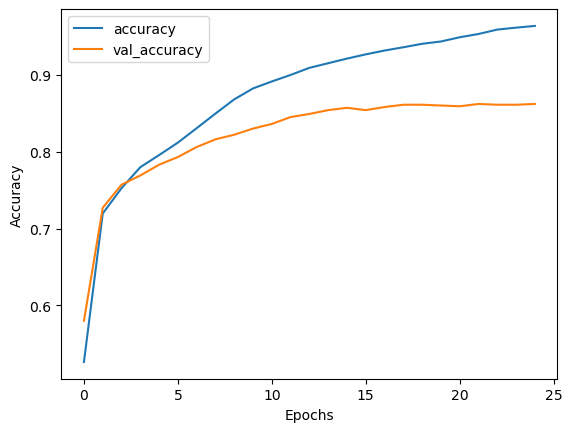

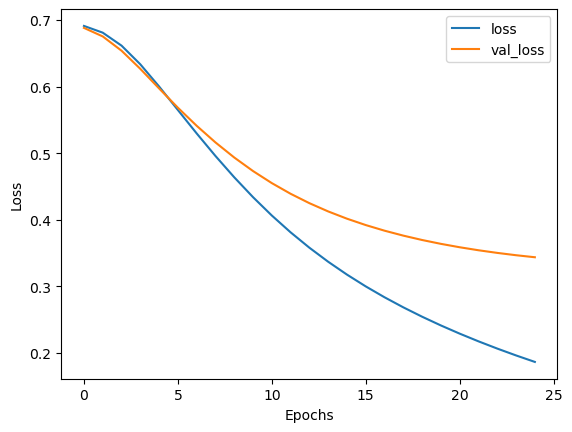

In [20]:
def plot_metrics(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric.title())
    plt.legend([metric, f'val_{metric}'])
    plt.show()
    
plot_metrics(history, "accuracy")
plot_metrics(history, "loss")

In [39]:
# a new sequential model using the vectorization layer and the model we just trained.
export_model = tf.keras.Sequential([
  vectorize_layer,
  model]
)

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

In [22]:
examples = ['this movie was very, very good', 'quite ok', 'the movie was not bad', 'bad', 'negative disappointed bad scary', 'this movie was stupid']

results = export_model.predict(examples, verbose=False)

for result, example in zip(results, examples):
    print(f'Result: {result[0]:.3f},   Label: {int(np.round(result[0]))},   Review: {example}')

Result: 0.602,   Label: 1,   Review: this movie was very, very good
Result: 0.517,   Label: 1,   Review: quite ok
Result: 0.403,   Label: 0,   Review: the movie was not bad
Result: 0.449,   Label: 0,   Review: bad
Result: 0.410,   Label: 0,   Review: negative disappointed bad scary
Result: 0.437,   Label: 0,   Review: this movie was stupid
